In [509]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import  sum as spark_sum, col,when ,hour, dayofweek, month, to_timestamp,mean, unix_timestamp
import pandas as pd
from pyspark.sql.types import IntegerType, DoubleType, StringType

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import joblib
spark = SparkSession.builder.appName('SmartLogi').getOrCreate()
df = spark.read.parquet('./data/dataset.parquet')
df.show()

26/01/08 15:17:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [510]:
# Nombre de lignes
num_lignes = df.count()

# Nombre de colonnes
num_colonnes = len(df.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")


Shape du dataset : (3475226, 20)


In [511]:
df.printSchema()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [512]:
df.describe().show()


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [513]:
df.summary().show()


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [514]:
numeric_cols = [field.name for field in df.schema.fields 
                if isinstance(field.dataType, (IntegerType, DoubleType))]
print("Colonnes numériques :", numeric_cols)


Colonnes numériques : ['VendorID', 'trip_distance', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee']


In [515]:
categorical_cols = [field.name for field in df.schema.fields 
                    if isinstance(field.dataType, StringType)]
print("Colonnes catégorielles :", categorical_cols)


Colonnes catégorielles : ['store_and_fwd_flag']


In [516]:
from pyspark.sql.functions import col

# Vérifier les colonnes avec beaucoup de nulls
df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]).show()

# Supprimer les lignes avec nulls uniquement sur les colonnes importantes
important_cols = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge', 'Airport_fee']
df_clean = df.dropna(subset=important_cols)

df_clean.show()


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|    

In [517]:
total_rows = df_clean.count()
distinct_rows = df_clean.distinct().count()

num_duplicates = total_rows - distinct_rows
print(f"Nombre de doublons : {num_duplicates}")


26/01/08 15:18:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
26/01/08 15:18:34 WARN RowBasedKeyValueBatch: Calling spill() on

Nombre de doublons : 0


In [518]:
# Nombre de lignes
num_lignes = df_clean.count()

# Nombre de colonnes
num_colonnes = len(df_clean.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")

Shape du dataset : (2935077, 20)


In [519]:

df_clean = df_clean.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime")))
df_clean = df_clean.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime")))

df_clean = df_clean.withColumn(
    "trip_duration_min",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/60
)
df_clean.select(
    spark_sum(when(col("trip_duration_min") < 0, 1).otherwise(0)).alias("duration_negative"),
    spark_sum(when(col("trip_duration_min") == 0, 1).otherwise(0)).alias("duration_zero"),
    spark_sum(when(col("trip_duration_min") > 0, 1).otherwise(0)).alias("duration_positive")
).show()


+-----------------+-------------+-----------------+
|duration_negative|duration_zero|duration_positive|
+-----------------+-------------+-----------------+
|                6|         1826|          2933245|
+-----------------+-------------+-----------------+



In [520]:
outliers_trip_distance = df_clean.filter((col("trip_distance") <= 0) | (col("trip_distance") > 200)).count()
outliers_fare = df_clean.filter(col("fare_amount") < 0).count()
outliers_tip = df_clean.filter(col("tip_amount") < 0).count()
outliers_tolls = df_clean.filter(col("tolls_amount") < 0).count()
outliers_total = df_clean.filter(col("total_amount") < 0).count()
outliers_vendor = df_clean.filter((col("VendorID") != 1) & (col("VendorID") != 2)).count()
outliers_ratecode = df_clean.filter(~col("RatecodeID").isin([1,2,3,4,5,6])).count()
outliers_passenger = df_clean.filter(col("passenger_count") <= 0).count()
outliers_duration = df_clean.filter(col("trip_duration_min") <= 0).count()

# Afficher le résultat
print(f"Outliers trip_distance: {outliers_trip_distance}")
print(f"Outliers fare_amount: {outliers_fare}")
print(f"Outliers tip_amount: {outliers_tip}")
print(f"Outliers tolls_amount: {outliers_tolls}")
print(f"Outliers total_amount: {outliers_total}")
print(f"Outliers VendorID: {outliers_vendor}")
print(f"Outliers RatecodeID: {outliers_ratecode}")
print(f"Outliers passenger_count: {outliers_passenger}")
print(f"Outliers trip_duration: {outliers_duration}")

Outliers trip_distance: 38922
Outliers fare_amount: 59296
Outliers tip_amount: 123
Outliers tolls_amount: 4559
Outliers total_amount: 59616
Outliers VendorID: 1206
Outliers RatecodeID: 41963
Outliers passenger_count: 24656
Outliers trip_duration: 1832


In [521]:


df_silver = df_clean \
    .filter((col("trip_distance") > 0) & (col("trip_distance") <= 200)) \
    .filter(col("fare_amount") >= 0) \
    .filter(col("total_amount") >= 0) \
    .filter(col("VendorID").isin([1,2])) \
    .filter(col("RatecodeID").isin([1,2,3,4,5,6])) \
    .filter(col("passenger_count") > 0) \
    .filter(col("trip_duration_min") > 0) \
    .withColumn("tip_amount", when(col("tip_amount") < 0, 0).otherwise(col("tip_amount"))) \
    .withColumn("tolls_amount", when(col("tolls_amount") < 0, 0).otherwise(col("tolls_amount")))


In [522]:
# Nombre de lignes
num_lignes = df_silver.count()

# Nombre de colonnes
num_colonnes = len(df_silver.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")

Shape du dataset : (2777079, 21)


In [523]:
df_silver = df_silver.filter(
    (col("trip_duration_min") > 0) &
    (col("trip_distance") > 0) & (col("trip_distance") <= 200) &
    (col("passenger_count") > 0) &
    (col("fare_amount") >= 0)
)


In [524]:
# Time-based features
df_silver = df_silver.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))
df_silver = df_silver.withColumn("pickup_dayofweek", dayofweek(col("tpep_pickup_datetime")))
df_silver = df_silver.withColumn("pickup_month", month(col("tpep_pickup_datetime")))


df_silver.show(15)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+----------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee| trip_duration_min|pickup_hour|pickup_dayofweek|pickup_month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+---------

In [525]:
corr_features = [
    "trip_duration_min",
    "trip_distance",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
    "cbd_congestion_fee",
    "passenger_count",
    "pickup_hour",
    "pickup_dayofweek",
    "pickup_month"
]



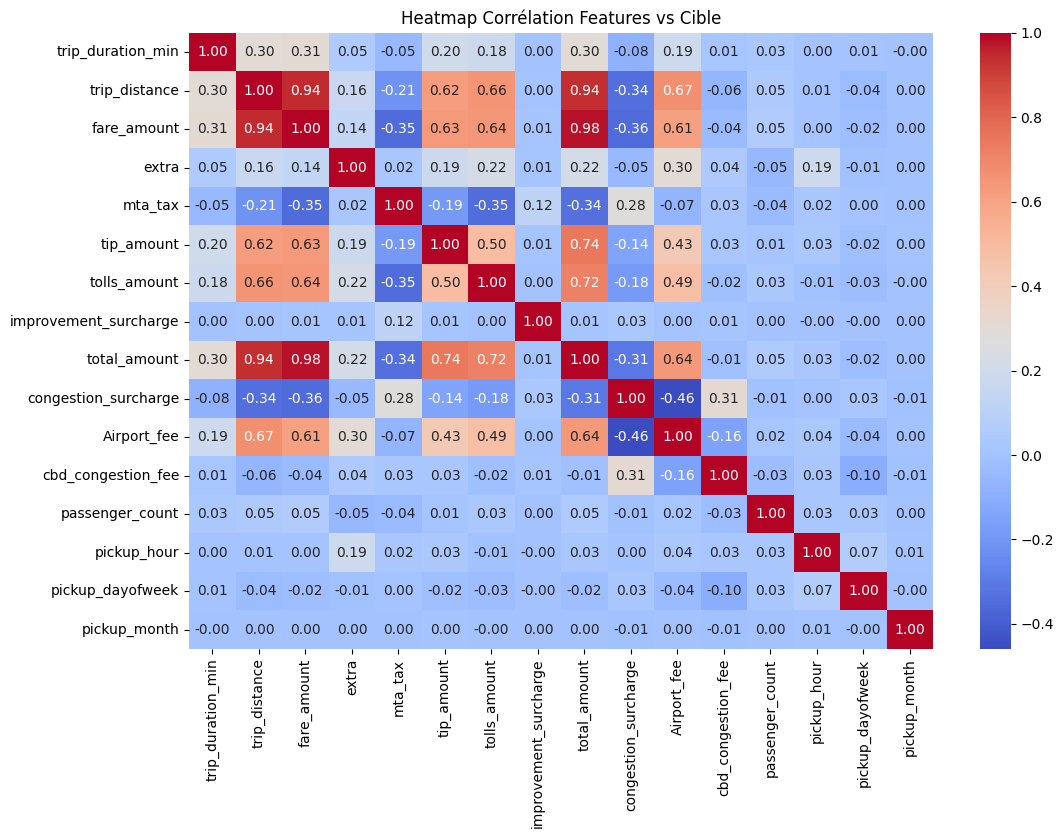

In [526]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df_silver.select(corr_features).sample(0.1).toPandas()
# Corrélation
corr_matrix = pdf.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap Corrélation Features vs Cible")
plt.show()


In [527]:


df_silver = df_silver.drop(
    "store_and_fwd_flag",
    "RatecodeID",
    "tip_amount",
    "congestion_surcharge",
    "improvement_surcharge",
    "VendorID",
)

# drop rows with nulls
df_silver = df_silver.dropna()

In [528]:
# Nombre de lignes
num_lignes = df_silver.count()

# Nombre de colonnes
num_colonnes = len(df_silver.columns)

print(f"Shape du dataset : ({num_lignes}, {num_colonnes})")


Shape du dataset : (2777079, 18)


In [529]:

df_silver_single = df_silver.coalesce(1)

df_silver_single.write.mode("overwrite").parquet("./data/silver/silver_dataset_single")


In [530]:
#df_silver.write.mode("overwrite").parquet("./data/silver/silver_dataset")


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("LoadSilverToPostgres") \
    .getOrCreate()

df_silver = spark.read.parquet("./data/silver/silver_dataset_single")

df_silver.printSchema()
print("Nombre de lignes :", df_silver.count())


root
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_dayofweek: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)



Nombre de lignes : 2777079


In [ ]:

# data_sample = df_silver.sample(fraction=0.02, seed=42)

In [ ]:

# data_pd = data_sample.toPandas()

In [ ]:
# #train ML model (linear regression)

# X = data_pd.drop("duration_minutes", axis=1)
# y = data_pd["duration_minutes"]

# # train-test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # linear Regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Predictions
# preds = model.predict(X_test)

# # Evaluation
# mae = mean_absolute_error(y_test, preds)
# print("Mean Absolute Error (MAE):", mae)